In [4]:
#실습 전 폴더 만들기

!mkdir -p ~/aiffel/human_segmentation/models
!mkdir -p ~/aiffel/human_segmentation/images

In [9]:
#urllib는 웹에서 데이터를 다운로드할 때 사용
#cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요
#pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리


import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(1440, 1080, 3)


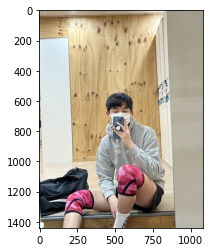

In [102]:
#선택한 이미지의 경로 맞추기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image9.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [83]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f126c41d520>)

In [84]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [85]:
# 모델에 이미지 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

In [86]:
#PASCAL VOC 데이터의 라벨 종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

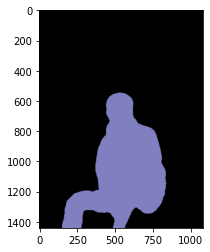

In [87]:
# 모델에서 나온 출력값

plt.imshow(output)
plt.show()

In [88]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [89]:
# segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 있는지 알 수 있다.

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


In [90]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [91]:
# 사람을 나타내는 15번째 색상은 무엇일까요?

colormap[15]

array([192, 128, 128])

In [92]:
# 여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점
# colormap은 RGB 순서
# 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

seg_color = (128,128,192)

(1440, 1080)


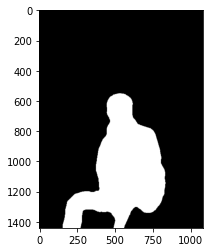

In [93]:
# 이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

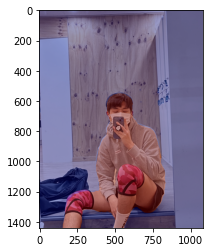

In [94]:
# 원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 확인 가능하다.

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

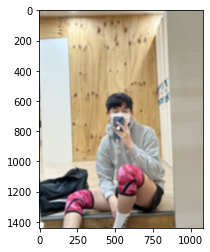

In [95]:
# 배경을 흐리게 만들어 보자

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

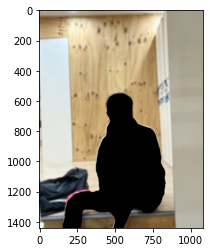

In [96]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

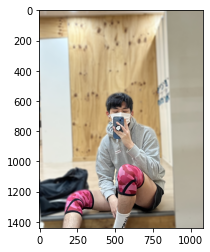

In [97]:
# 배경 영상과 사람 영상을 겹쳐보자!

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(1440, 1166, 3)


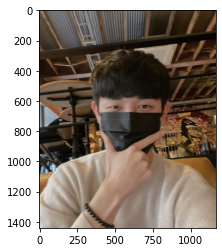

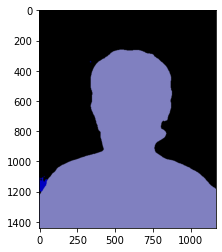

background
chair
person
(1440, 1166)


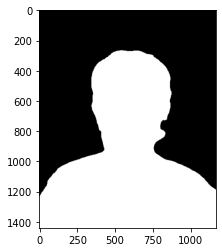

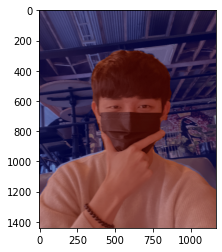

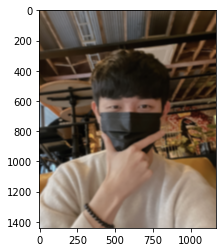

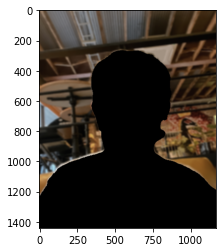

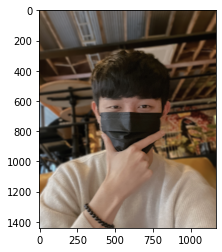

In [106]:
#선택한 이미지의 경로 맞추기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image10.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

# 모델에서 나온 출력값

plt.imshow(output)
plt.show()

segvalues

# segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 있는지 알 수 있다.

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

# 여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점
# colormap은 RGB 순서
# 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

seg_color = (128,128,192)

# 이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

# 원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 확인 가능하다.

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 배경을 흐리게 만들어 보자

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 영상과 사람 영상을 겹쳐보자!

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(1440, 1080, 3)


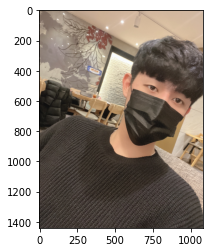

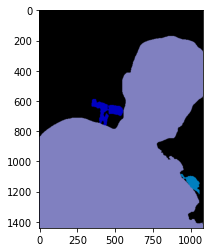

background
chair
diningtable
person
(1440, 1080)


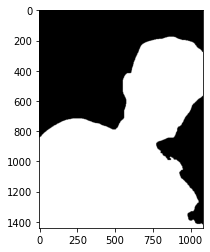

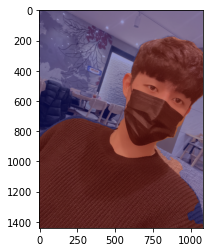

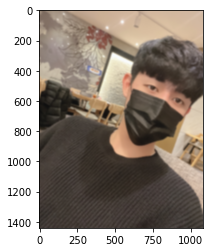

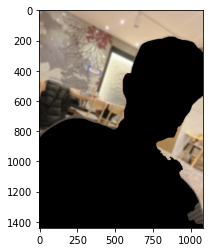

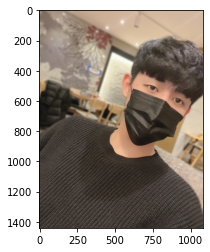

In [107]:
#선택한 이미지의 경로 맞추기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image11.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

# 모델에서 나온 출력값

plt.imshow(output)
plt.show()

segvalues

# segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 있는지 알 수 있다.

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

# 여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점
# colormap은 RGB 순서
# 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

seg_color = (128,128,192)

# 이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

# 원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 확인 가능하다.

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 배경을 흐리게 만들어 보자

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 영상과 사람 영상을 겹쳐보자!

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(1080, 1440, 3)


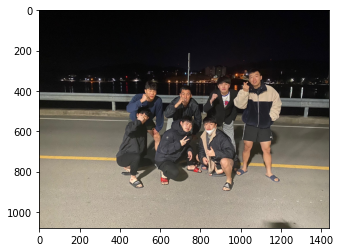

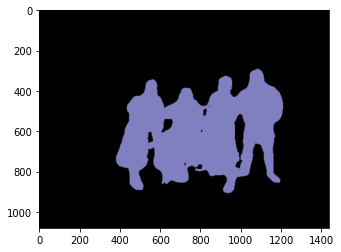

background
person
(1080, 1440)


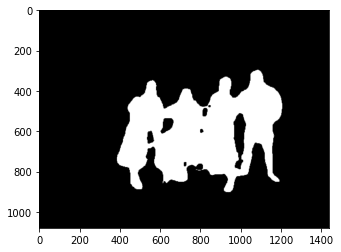

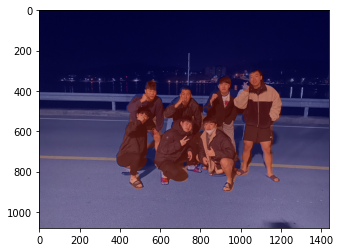

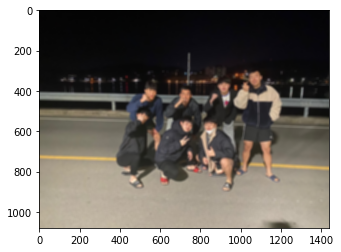

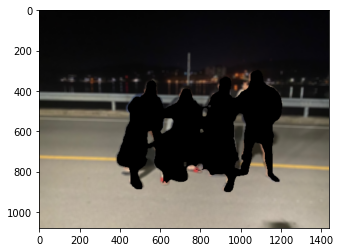

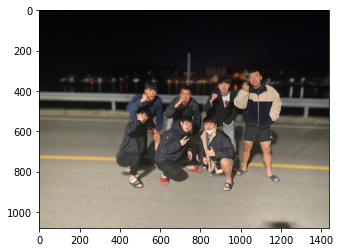

In [109]:
#선택한 이미지의 경로 맞추기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image8.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

# 모델에서 나온 출력값

plt.imshow(output)
plt.show()

segvalues

# segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 있는지 알 수 있다.

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

# 여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점
# colormap은 RGB 순서
# 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

seg_color = (128,128,192)

# 이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

# 원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 확인 가능하다.

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 배경을 흐리게 만들어 보자

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 영상과 사람 영상을 겹쳐보자!

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()